In [ ]:
!wget https://github.com/dasoto/skincancer/raw/refs/heads/master/models/mymodel-2.h5

--2025-08-11 08:09:48--  https://github.com/dasoto/skincancer/raw/refs/heads/master/models/mymodel-2.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dasoto/skincancer/refs/heads/master/models/mymodel-2.h5 [following]
--2025-08-11 08:09:49--  https://raw.githubusercontent.com/dasoto/skincancer/refs/heads/master/models/mymodel-2.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10025768 (9.6M) [application/octet-stream]
Saving to: ‘mymodel-2.h5’

mymodel-2.h5        100%[===================>]   9.56M  --.-KB/s    in 0.06s   

2025-08-11 08:09:51 (153 MB/s) - ‘mymodel-2.h5’ saved [10025768/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import torch
import torch.nn as nn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import cv2
import albumentations
from tqdm import tqdm

In [ ]:
import gdown

gdown.download_folder('https://drive.google.com/drive/folders/1UKUZZ6uTdEVdGWEKNh0ZRp08pK_AVnrm', output='Download')

Retrieving folder contents


Processing file 1wHcBG5ScNKOxQixT6XZElaYYnLe5YtTh images.hdf5
Processing file 19NhzTlMREy2ct5kaXJyuZjSrgrSq2zIOMSiiTuGCPbI metadata
Processing file 1RZTnXKRaoVzszG8zQgBgmdnGyGXL_CO3rmbf3QpDNbU Problem Statement
Processing file 1N9oQCi5zklHrv-AXRF6RBiiAzmxc4i2y subject_data.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1wHcBG5ScNKOxQixT6XZElaYYnLe5YtTh
From (redirected): https://drive.google.com/uc?id=1wHcBG5ScNKOxQixT6XZElaYYnLe5YtTh&confirm=t&uuid=46322a91-77e2-4141-b2ae-7cffe1fd928e
To: /content/Download/images.hdf5
100%|██████████| 1.30G/1.30G [00:10<00:00, 128MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=19NhzTlMREy2ct5kaXJyuZjSrgrSq2zIOMSiiTuGCPbI
From (redirected): https://docs.google.com/spreadsheets/d/19NhzTlMREy2ct5kaXJyuZjSrgrSq2zIOMSiiTuGCPbI/export?format=xlsx
To: /content/Download/metadata
52.7kB [00:00, 1.67MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1RZTnXKRaoVzszG8zQgBgmdnGyGXL_CO3rmbf3QpDNbU
From (redirected): https://docs.google.com/document/d/1RZTnXKRaoVzszG8zQgBgmdnGyGXL_CO3rmbf3QpDNbU/export?format=docx
To: /content/Download/Problem Statement
78.3kB [00:00, 289kB/s]

['Download/images.hdf5',
 'Download/metadata',
 'Download/Problem Statement',
 'Download/subject_data.csv']

In [ ]:
gdown.download('https://drive.google.com/uc?id=1N9oQCi5zklHrv-AXRF6RBiiAzmxc4i2y', output='Download/subject_data.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1N9oQCi5zklHrv-AXRF6RBiiAzmxc4i2y
From (redirected): https://drive.google.com/uc?id=1N9oQCi5zklHrv-AXRF6RBiiAzmxc4i2y&confirm=t&uuid=a92fabc2-105c-4472-baef-aef71a5668bc
To: /content/Download/subject_data.csv
100%|██████████| 258M/258M [00:02<00:00, 108MB/s] 


'Download/subject_data.csv'

In [ ]:
df = pd.read_csv('Download/subject_data.csv')
print(df)
df.columns

/tmp/ipython-input-2662961776.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Download/subject_data.csv')


             isic_id  target  patient_id  age_approx     sex  \
0       ISIC_0015670       0  IP_1235828        60.0    male   
1       ISIC_0015845       0  IP_8170065        60.0    male   
2       ISIC_0015864       0  IP_6724798        60.0    male   
3       ISIC_0015902       0  IP_4111386        65.0    male   
4       ISIC_0024200       0  IP_8313778        55.0    male   
...              ...     ...         ...         ...     ...   
401054  ISIC_9999937       0  IP_1140263        70.0    male   
401055  ISIC_9999951       0  IP_5678181        60.0    male   
401056  ISIC_9999960       0  IP_0076153        65.0  female   
401057  ISIC_9999964       0  IP_5231513        30.0  female   
401058  ISIC_9999967       0  IP_6426047        50.0    male   

       anatom_site_general  clin_size_long_diam_mm          image_type  \
0          lower extremity                    3.04  TBP tile: close-up   
1                head/neck                    1.10  TBP tile: close-up   
2        

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [ ]:
meta_features = ['age_approx', 'sex', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_minorAxisMM', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle']

In [ ]:
# !pip install h5py
import h5py
images_file = 'Download/images.hdf5'


images_hdf5 = h5py.File(images_file, 'r')
img_keys = list(images_hdf5.keys())


def get_img(key):
  if key not in img_keys: return None
  img = Image.open(io.BytesIO(images_hdf5[key][()]))
  return np.array(img)

def get_img_pil(key):
  if key not in img_keys: return None
  return Image.open(io.BytesIO(images_hdf5[key][()]))


In [ ]:
import os
from PIL import Image
import io
import h5py
from tqdm.auto import tqdm



output_dir = 'Images'
os.makedirs(output_dir, exist_ok=True)

print(f"Extracting images from {images_file} to {output_dir}...")

for img_id in tqdm(img_keys, desc="Extracting Images"):
    try:
        img_data = images_hdf5[img_id][()]
        img = Image.open(io.BytesIO(img_data))
        img_path = os.path.join(output_dir, f"{img_id}.jpg") # Save as JPEG
        img.save(img_path)
    except Exception as e:
        print(f"Error extracting image {img_id}: {e}")

print("Image extraction complete.")

images_hdf5.close()

Extracting images from Download/images.hdf5 to Images...


Extracting Images:   0%|          | 0/401059 [00:00<?, ?it/s]

Image extraction complete.


Testing out models by made by others on our dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model
model = load_model('mymodel-2.h5')

# You can then print the model summary to verify
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 activation_2 (Activation)   (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                    

In [ ]:
!pip uninstall keras -y

!pip install keras==2.12.0

Found existing installation: keras 3.11.1
Uninstalling keras-3.11.1:
  Successfully uninstalled keras-3.11.1
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires keras>=3.5.0, but you have keras 2.12.0 which is incompatible.
keras-hub 0.21.1 requires keras>=3.5, but you have keras 2.12.0 which is incompatible.


In [ ]:
!pip uninstall tensorflow -y

!pip install tensorflow==2.12.0

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58

In [ ]:
malignant = df[df['target'] == 1]
benign = df[df['target'] == 0]

imgs = [np.array(get_img_pil(malignant.iloc[i]['isic_id']).resize(128, 128)) for i in range(len(malignant))]

ValueError: Unknown resampling filter (128). Use Image.Resampling.NEAREST (0), Image.Resampling.LANCZOS (1), Image.Resampling.BILINEAR (2), Image.Resampling.BICUBIC (3), Image.Resampling.BOX (4) or Image.Resampling.HAMMING (5)

In [ ]:
img = get_img_pil(malignant.iloc[4]['isic_id']).resize((128, 128))

model(np.array(img).reshape(1, 128, 128, 3))

In [ ]:
from PIL import Image

imgs_malig = np.array([
    np.array(get_img_pil(malignant.iloc[i]['isic_id']).resize((128, 128), Image.Resampling.BICUBIC)) for i in range(len(malignant))
])

imgs_benign = np.array([
    np.array(get_img_pil(benign.iloc[i]['isic_id']).resize((128, 128), Image.Resampling.BICUBIC)) for i in np.random.random_integers(0, len(benign), 5*len(malignant))
])

/tmp/ipython-input-263632761.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 400666 + 1) instead
  np.array(get_img_pil(benign.iloc[i]['isic_id']).resize((128, 128), Image.Resampling.BICUBIC)) for i in np.random.random_integers(0, len(benign), 5*len(malignant))


In [ ]:
preds_malig = model.predict(imgs_malig)
preds_benign = model.predict(imgs_benign)

62/62 [==============================] - 12s 194ms/step


In [ ]:
(preds_malig.reshape((-1)) > 0.9).sum() / len(malignant)

0.5597964376590331

In [ ]:
(preds_benign.reshape((-1)) < 0.9).sum() / len(imgs_benign)

0.5348600508905852

Solution Model

In [ ]:
class CancerDataset(Dataset):
    def __init__(self, csv, mode, meta_features, transform=None, imgs_dir="Images"):

        self.csv = csv.reset_index(drop=True)
        self.mode = mode
        self.meta_features = meta_features

        self.meta_df = self.csv[self.meta_features]
        self.transform = transform
        self.imgs_dir = imgs_dir


    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):

        row = self.csv.iloc[index]
        img_id = row.isic_id
        image_path = os.path.join(self.imgs_dir, f"{img_id}.jpg")

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)

        meta_data = self.meta_df.iloc[index].values.astype(np.float32)
        data = (torch.tensor(image).float(), torch.tensor(meta_data).float())

        if self.mode == 'test':
            return data
        else:
            return data, torch.tensor(self.csv.iloc[index].target).long()

In [ ]:
def get_transforms(image_size):

    transforms_train = albumentations.Compose([
        albumentations.Transpose(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
        albumentations.OneOf([
            albumentations.MotionBlur(blur_limit=5),
            albumentations.MedianBlur(blur_limit=5),
            albumentations.GaussianBlur(blur_limit=5),
            albumentations.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        albumentations.OneOf([
            albumentations.OpticalDistortion(distort_limit=1.0),
            albumentations.GridDistortion(num_steps=5, distort_limit=1.),
            albumentations.ElasticTransform(alpha=3),
        ], p=0.7),

        albumentations.CLAHE(clip_limit=4.0, p=0.7),
        albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        albumentations.Resize(image_size, image_size),
        albumentations.Normalize()
    ])

    transforms_val = albumentations.Compose([
        albumentations.Resize(image_size, image_size),
        albumentations.Normalize()
    ])

    return transforms_train, transforms_val

In [ ]:
!pip install geffnet git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-rphipmnw
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-rphipmnw
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 7021d63a49106e22c79b40564a7d39930e7b0f53
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import geffnet


sigmoid = nn.Sigmoid()


class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)


class Effnet(nn.Module):
    def __init__(self, enet_type, out_dim, n_meta_features=0, n_meta_dim=[512, 128], pretrained=False):
        nn.Module.__init__(self)
        self.n_meta_features = n_meta_features
        self.enet = geffnet.create_model(enet_type, pretrained=pretrained)
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        in_ch = self.enet.classifier.in_features
        if n_meta_features > 0:
            self.meta = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                Swish_Module(),
                nn.Dropout(p=0.3),
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                Swish_Module(),
            )
            in_ch += n_meta_dim[1]
        self.myfc = nn.Linear(in_ch, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x).squeeze(-1).squeeze(-1)
        if self.n_meta_features > 0:
            x_meta = self.meta(x_meta)
            x = torch.cat((x, x_meta), dim=1)
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                out = self.myfc(dropout(x))
            else:
                out += self.myfc(dropout(x))
        out /= len(self.dropouts)
        return out

In [ ]:
from warmup_scheduler import GradualWarmupScheduler

class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [ ]:
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR


def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:

        optimizer.zero_grad()

        if args.use_meta:
            data, meta = data
            data, meta, target = data.to(device), meta.to(device), target.to(device)
            logits = model(data, meta)
        else:
            data, target = data.to(device), target.to(device)
            logits = model(data)

        loss = criterion(logits, target)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))

    train_loss = np.mean(train_loss)
    return train_loss


def get_trans(img, I):

    if I >= 4:
        img = img.transpose(2, 3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)


def val_epoch(model, loader, mel_idx, is_ext=None, n_test=1, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PROBS = []
    TARGETS = []
    with torch.no_grad():
        for (data, target) in tqdm(loader):

            if args.use_meta:
                data, meta = data
                data, meta, target = data.to(device), meta.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], args.out_dim)).to(device)
                probs = torch.zeros((data.shape[0], args.out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I), meta)
                    logits += l
                    probs += l.softmax(1)
            else:
                data, target = data.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], args.out_dim)).to(device)
                probs = torch.zeros((data.shape[0], args.out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I))
                    logits += l
                    probs += l.softmax(1)
            logits /= n_test
            probs /= n_test

            LOGITS.append(logits.detach().cpu())
            PROBS.append(probs.detach().cpu())
            TARGETS.append(target.detach().cpu())

            loss = criterion(logits, target)
            val_loss.append(loss.detach().cpu().numpy())

    val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS).numpy()
    PROBS = torch.cat(PROBS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()

    if get_output:
        return LOGITS, PROBS, TARGETS
    else:
      acc = (probs.argmax(1) == targets).mean() * 100.
      auc = roc_auc_score((targets == mel_idx).astype(float), probs[:, mel_idx])

      return val_loss, acc, auc



def run(fold, df, meta_features, n_meta_features, transforms_train, transforms_val, mel_idx, model=None, optim=None, scheduler=None):
    df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)

    dataset_train = CancerDataset(df_train, 'train', meta_features, transform=transforms_train)
    dataset_valid = CancerDataset(df_valid, 'valid', meta_features, transform=transforms_val)

    class_counts = df_train['target'].value_counts().sort_index()
    class_weights_dict = (1. / class_counts).to_dict()
    samples_weight = df_train['target'].map(class_weights_dict)
    sampler = WeightedRandomSampler(list(samples_weight.values), num_samples=len(samples_weight), replacement=True)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, sampler=sampler, num_workers=args.num_workers)
    print("Has Imbalance!")


    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=args.batch_size, num_workers=args.num_workers)

    if isinstance(args.n_meta_dim, str):
        n_meta_dim_list = [int(nd) for nd in args.n_meta_dim.split(',')]
    else:
        n_meta_dim_list = args.n_meta_dim

    if model is None:
        model = ModelClass(
            args.enet_type,
            n_meta_features=n_meta_features,
            n_meta_dim=n_meta_dim_list,
            out_dim=args.out_dim,
            pretrained=True
        )
    else:
      print("Model found, using pretrained one")
    model = model.to(device)

    auc_max = 0.
    model_file  = os.path.join(args.model_dir, f'{args.kernel_type}_best_fold{fold}.pth')
    model_file3 = os.path.join(args.model_dir, f'{args.kernel_type}_final_fold{fold}.pth')
    scheduler_file = os.path.join(args.model_dir, f'{args.kernel_type}_scheduler_final_fold{fold}.pth')
    optim_file = os.path.join(args.model_dir, f'{args.kernel_type}_optim_final_fold{fold}.pth')

    optimizer = optim
    if optimizer is None: optimizer = optim.Adam(model.parameters(), lr=args.init_lr)
    if DP:
        model = nn.DataParallel(model)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, args.n_epochs - 1)
    scheduler_warmup = scheduler
    if scheduler_warmup is not None: scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, args.n_epochs + 1):
        print(time.ctime(), f'Fold {fold}, Epoch {epoch}')

        train_loss = train_epoch(model, train_loader, optimizer)
        val_loss, acc, auc = val_epoch(model, valid_loader, mel_idx, is_ext=df_valid['is_ext'].values if 'is_ext' in df_valid.columns else None)


        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {(val_loss):.5f}, acc: {(acc):.4f}, auc: {(auc):.6f}.'
        print(content)

        scheduler_warmup.step()
        if epoch==2: scheduler_warmup.step()

        if auc > auc_max:
            print('Saving model ...'.format(auc_max, auc))
            torch.save(model.state_dict(), model_file)
            auc_max = auc

        torch.save(optimizer.state_dict(), optim_file)
        torch.save(scheduler_warmup.state_dict(), scheduler_file)

    torch.save(model.state_dict(), model_file3)


def main():

    df, meta_features, n_meta_features, mel_idx = get_df(
        args.kernel_type,
        args.out_dim,
        args.data_dir,
        args.data_folder,
        args.use_meta
    )

    transforms_train, transforms_val = get_transforms(args.image_size)

    folds = [int(i) for i in args.fold.split(',')]
    for fold in folds:
        run(fold, df, meta_features, n_meta_features, transforms_train, transforms_val, mel_idx)

In [ ]:
args = argparse.Namespace()
args.model_dir = "Models"
args.log_dir = "Logs"
args.CUDA_VISIBLE_DEVICES = "0"
args.enet_type = 'efficientnet_b3'
args.kernel_type = 'efficientnet'
args.n_meta_dim = [512, 128]
args.out_dim = 2
args.data_dir = '/content'
args.data_folder = 'Download'
args.use_meta = True
args.batch_size = 32
args.num_workers = 2
args.image_size = 128
args.fold = 0
args.n_epochs = 5
args.init_lr = 1e-4
args.DEBUG = False

os.makedirs(args.model_dir, exist_ok=True)
os.makedirs(args.log_dir, exist_ok=True)
os.environ['CUDA_VISIBLE_DEVICES'] = args.CUDA_VISIBLE_DEVICES
DP = len(os.environ['CUDA_VISIBLE_DEVICES']) > 1

set_seed()

device = torch.device('cuda')
criterion = nn.CrossEntropyLoss()

In [ ]:
from sklearn.model_selection import StratifiedKFold

def get_df(kernel_type, out_dim, data_dir, data_folder, use_meta):
    df = pd.read_csv(os.path.join(data_dir, data_folder, 'subject_data.csv'), low_memory=False)
    df = df[df['image_type'] == 'TBP tile: close-up']

    if use_meta:
        meta_features = ['age_approx', 'sex', 'clin_size_long_diam_mm',
       'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_minorAxisMM', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle']

        if 'age_approx' in meta_features:
            df['age_approx'] = df['age_approx'].fillna(df['age_approx'].mean())

        if 'sex' in meta_features:
            df['sex'] = df['sex'].fillna(df['sex'].mode()[0])

        if 'sex' in meta_features:
            df = pd.get_dummies(df, columns=['sex'], dummy_na=False)
            meta_features.remove('sex')
            meta_features.extend([col for col in df.columns if 'sex_' in col])

        if 'tbp_lv_location' in meta_features:
             df = pd.get_dummies(df, columns=['tbp_lv_location'], dummy_na=False)
             meta_features.remove('tbp_lv_location')
             meta_features.extend([col for col in df.columns if 'tbp_lv_location_' in col and col != 'tbp_lv_location_simple'])

        for col in meta_features:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                if df[col].isnull().any():
                    if df[col].dtype == 'float64':
                         df[col] = df[col].fillna(df[col].mean())
                    else:
                         df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 0)


        n_meta_features = len([col for col in df.columns if col in meta_features])

    else:
        meta_features = None
        n_meta_features = 0

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(df, df['target'])):
        df.loc[val_index, 'fold'] = fold

    mel_idx = sorted(df['target'].unique()).index(1)


    return df, meta_features, n_meta_features, mel_idx

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

args.kernel_type = 'efficientnet'
args.out_dim = 2
args.data_dir = '/content'
args.data_folder = 'Download'
args.use_meta = True
args.batch_size = 1024
args.num_workers = 2
args.image_size = 64

df, meta_features, n_meta_features, mel_idx = get_df(
    args.kernel_type,
    args.out_dim,
    args.data_dir,
    args.data_folder,
    args.use_meta
)

fold = 0

transforms_train, transforms_val = get_transforms(args.image_size)

df_train = df[df['fold'] != fold]
df_valid = df[df['fold'] == fold]

dataset_train = CancerDataset(df_train, 'train', meta_features, transform=transforms_train)
dataset_valid = CancerDataset(df_valid, 'valid', meta_features, transform=transforms_val)

class_weights = compute_class_weight('balanced',
                                   classes=np.unique(df['target']),
                                   y=df['target'])
class_weight_dict = dict(zip(np.unique(df['target']), class_weights))
sample_weights = df_valid['target'].map(class_weight_dict)
sampler = WeightedRandomSampler(list(sample_weights), num_samples=len(df_valid), replacement=True)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, sampler=RandomSampler(dataset_train), num_workers=args.num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=args.batch_size, num_workers=args.num_workers)

/tmp/ipython-input-1676629069.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  albumentations.GaussNoise(var_limit=(5.0, 30.0)),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
model = Eff(
    args.enet_type,
    n_meta_features=n_meta_features,
    n_meta_dim=[int(nd) for nd in args.n_meta_dim.split(',')] if isinstance(args.n_meta_dim, str) else args.n_meta_dim,
    out_dim=args.out_dim,
    pretrained=True
)
model = model.to(device)

# Define Optimizer and Criterion
optimizer = optim.Adam(model.parameters(), lr=args.init_lr)
criterion = nn.CrossEntropyLoss()

# Define Learning Rate Scheduler (already partially defined in run function)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, args.n_epochs - 1)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

print("Model initialized, optimizer and criterion defined.")

Model initialized, optimizer and criterion defined.


In [ ]:
import gdown

gdown.download('https://drive.google.com/uc?id=1mhUxIruru3-6p1rElYEmVU9Km8RrGZkj')
gdown.download('https://drive.google.com/uc?id=1JTwakTbXdN1jFfYG2bRggaiUHPsqdLLA')
gdown.download('https://drive.google.com/uc?id=1hrWsuoC54fClnCtvxUWgdMGbNAOGeb6K')
gdown.download('https://drive.google.com/uc?id=17qNSQTWKz9aiwpcc36PuHRMzESehJeRK')
model.load_state_dict(torch.load('efficientnet_best_fold2.pth', weights_only=False))
model.load_state_dict(torch.load('efficientnet_best_fold0.pth', weights_only=False))
optimizer.load_state_dict(torch.load('efficientnet_optim_final_fold2.pth', weights_only=False))
scheduler_warmup.load_state_dict(torch.load('efficientnet_scheduler_final_fold2.pth', weights_only=False))
# scheduler_warmup.load_state_dict()

Downloading...
From (original): https://drive.google.com/uc?id=1mhUxIruru3-6p1rElYEmVU9Km8RrGZkj
From (redirected): https://drive.google.com/uc?id=1mhUxIruru3-6p1rElYEmVU9Km8RrGZkj&confirm=t&uuid=f414e97d-823b-47e1-896d-b2ad9ac4b1ae
To: /content/efficientnet_scheduler_final_fold2.pth
100%|██████████| 130M/130M [00:01<00:00, 117MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1JTwakTbXdN1jFfYG2bRggaiUHPsqdLLA
From (redirected): https://drive.google.com/uc?id=1JTwakTbXdN1jFfYG2bRggaiUHPsqdLLA&confirm=t&uuid=b494d83f-b0c9-4c64-84e0-abc21eeddf32
To: /content/efficientnet_optim_final_fold2.pth
100%|██████████| 86.7M/86.7M [00:00<00:00, 177MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1hrWsuoC54fClnCtvxUWgdMGbNAOGeb6K
From (redirected): https://drive.google.com/uc?id=1hrWsuoC54fClnCtvxUWgdMGbNAOGeb6K&confirm=t&uuid=b19885ba-f746-4d03-a376-2dcfceff649a
To: /content/efficientnet_best_fold2.pth
100%|██████████| 43.7M/43.7M [00:00<00:00, 124MB/s]
Downlo

In [ ]:
# Execute Training
fold = 0
run(fold, df, meta_features, n_meta_features, transforms_train, transforms_val, mel_idx, model, optimizer, scheduler_warmup)

print("Training complete.")

Has Imbalance!
Model found, using pretrained one
320847 80212
Mon Aug 11 17:07:58 2025 Fold 0, Epoch 1


100%|██████████| 79/79 [01:13<00:00,  1.08it/s]


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=args.batch_size, num_workers=args.num_workers)

val_out = val_epoch(model, valid_loader, mel_idx, get_output=True)

 18%|█▊        | 14/79 [00:15<00:43,  1.48it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1b06602340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
      Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1b06602340>
  Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^i

In [ ]:
logits, probs, targets = val_out

acc = (probs.argmax(1) == targets).mean() * 100.
auc = roc_auc_score((targets == mel_idx).astype(float), probs[:, mel_idx])

acc, auc

(np.float64(95.3448361841121), np.float64(0.986642246032767))

In [ ]:
from sklearn.metrics import confusion_matrix

preds = probs.argmax(1)

tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

sensitivity, specificity, ppv, npv

(np.float64(0.9358974358974359),
 np.float64(0.9534654453789901),
 np.float64(0.019200420831141506),
 np.float64(0.9999345635388038))

With weighted sampler

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.utils.data import WeightedRandomSampler

class_weights = compute_class_weight('balanced',
                                   classes=np.unique(df['target']),
                                   y=df['target'])
class_weight_dict = dict(zip(np.unique(df['target']), class_weights))
sample_weights = df_valid['target'].map(class_weight_dict)
sampler = WeightedRandomSampler(list(sample_weights), num_samples=len(df_valid), replacement=True)

valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=args.batch_size, num_workers=args.num_workers, sampler=sampler)

val_out = val_epoch(model, valid_loader, mel_idx, get_output=True)

 20%|██        | 16/79 [00:13<00:40,  1.55it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1b06602340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1b06602340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-pa

In [ ]:
logits, probs, targets = val_out

acc = (probs.argmax(1) == targets).mean() * 100.
auc = roc_auc_score((targets == mel_idx).astype(float), probs[:, mel_idx])

acc, auc

(np.float64(94.43350122176233), np.float64(0.9862252231396866))

In [ ]:
from sklearn.metrics import confusion_matrix

preds = probs.argmax(1)

tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

sensitivity, specificity, ppv, npv

(np.float64(0.9367012928779613),
 np.float64(0.9519828296189073),
 np.float64(0.9513231796791985),
 np.float64(0.9375460846482819))

In [ ]:
batch = next(iter(valid_loader))

In [ ]:
batch[1].sum()

tensor(475)

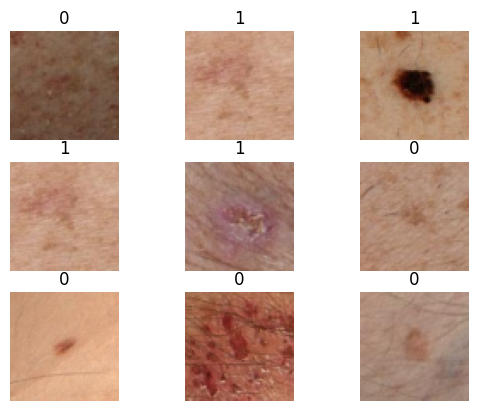

In [ ]:
image_tensor = batch[0][0] if args.use_meta else batch[0]

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

mean = mean.reshape((-1, 1, 1, 3))
std = std.reshape((-1, 1, 1, 3))


image_denormalized = image_tensor.permute(0, 2, 3, 1).numpy() * std + mean

image_display = np.clip(image_denormalized, 0, 1)

for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, 3*i+j+1)
        ind = np.random.randint(0, len(image_display))
        plt.imshow(image_display[ind])
        plt.title(f"{batch[1][ind]}")
        plt.axis('off')
plt.show()

In [ ]:
batch[0][1][1]

tensor([65.0000,  3.9300, 18.4709, 11.6853, 22.7278, 20.0719, 29.2870, 23.2256,
        50.8992, 59.7933, 36.0085, 43.7583,  9.4202, 17.0172,  0.9403,  6.7857,
         2.6559, -7.7498,  8.3089,  7.5012,  0.7023,  2.8334,  2.4864,  2.8100,
        12.6611,  0.9347,  2.0589,  5.8353,  0.2261,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000])

In [ ]:
from numba import cuda

dev = cuda.get_current_device()
dev.reset()

In [ ]:
from sklearn.metrics import confusion_matrix


preds = probs.argmax(1)

tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()

print(f"Confusion Matrix:\n[[{tn}, {fp}], [{fn}, {tp}]]")

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value (Precision): {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")
print(f"F1 Score: {f1_score:.4f}")

from sklearn.metrics import roc_auc_score
auc = roc_auc_score((targets == mel_idx).astype(float), probs[:, mel_idx])
print(f"AUC: {auc:.4f}")

Confusion Matrix:
[[38145, 1924], [2541, 37602]]

Accuracy: 0.9443
Sensitivity (Recall): 0.9367
Specificity: 0.9520
Positive Predictive Value (Precision): 0.9513
Negative Predictive Value: 0.9375
F1 Score: 0.9440
AUC: 0.9862


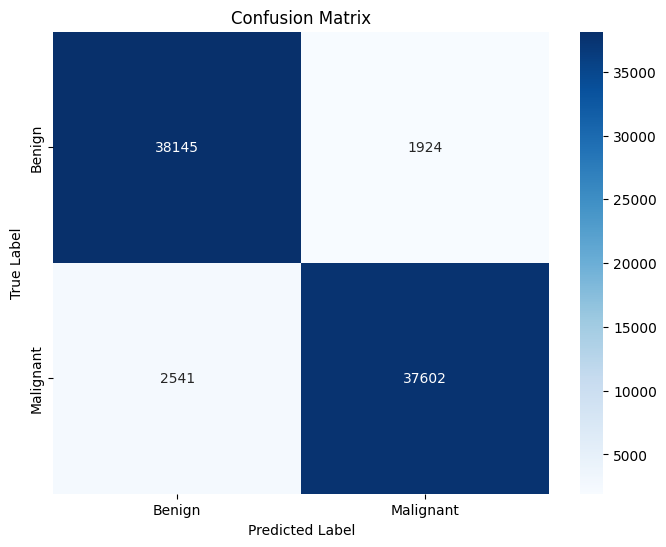

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(targets, preds)

class_labels = ['Benign', 'Malignant']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'efficientnet_best_fold0_10ep.pth')